# Evolution de la probabilité que plus d'électeurs aient l'intention de voter pour tel candidat

In [21]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

import numpy as np
import requests

from pollsposition.plots import sample_uncertainty

In [22]:
NUM_SAMPLES=10_000

## Données

On récupère dans un premier temps les données présentes dans la base. On se limite à l'hypothèse où Xavier Bertrand est candidat de la droite à chaque fois (même s'il y a d'infimes variations d'un sondage à l'autre parfois).

In [138]:
r = requests.get("https://raw.githubusercontent.com/pollsposition/data/main/presidentielles/sondages.json")
polls = r.json()

In [139]:
posterior = {}
for poll_id, poll in polls.items():
    num_sample = poll['echantillon']
    
    posterior[poll_id] = []
    for hypothese in poll['premier_tour'].values():
    
        exprimes = hypothese['intentions_exprimees']
        if not exprimes:
            exprimes = 70

        num_exprimes = int(num_sample * exprimes / 100)
        posterior[poll_id].append(sample_uncertainty(num_exprimes, hypothese['intentions'], samples=10_000))

## Probabilité pour que plus de personnes aient l'intention de voter pour Mélenchon plutôt qu'Hidalgo 

In [140]:
p_melenchon_greater = {}
for poll_id in posterior:
    p_melenchon_greater[poll_id] = []
    for hyp in posterior[poll_id]:
        if 'Jean-Luc Mélenchon' in hyp and 'Anne Hidalgo' in hyp:
            p_melenchon_greater[poll_id].append(int(100 * np.sum(hyp['Jean-Luc Mélenchon'] > hyp['Anne Hidalgo']) / NUM_SAMPLES))

In [141]:
{k : int(np.mean(v)) for k,v in p_melenchon_greater.items()}

{'20210903_ipsos': 32,
 '20210830_harris': 99,
 '20210822_ipsos': 19,
 '20210823_harris': 99,
 '20210705_harris': 98,
 '20210702_ifop': 67,
 '20210628_harris': 97,
 '20210621_harris': 98,
 '20210614_harris': 99,
 '20210607_harris': 100,
 '20210524_harris': 99,
 '20210517_harris': 100,
 '20210419_harris': 99}

## $P(I_{Le Pen} > I_{Macron})$

In [142]:
p_lepen_greater = {}
for poll_id in posterior:
    p_lepen_greater[poll_id] = []
    for hyp in posterior[poll_id]:
        if 'Éric Zemmour' not in hyp and 'Xavier Bertrand' in hyp:
            p_lepen_greater[poll_id].append(int(100 * np.sum(hyp['Marine Le Pen'] > hyp['Emmanuel Macron']) / NUM_SAMPLES))

In [143]:
p_lepen_greater

{'20210903_ipsos': [16],
 '20210830_harris': [33, 31],
 '20210822_ipsos': [],
 '20210823_harris': [50, 49, 83],
 '20210705_harris': [49],
 '20210702_ifop': [82, 17, 67],
 '20210628_harris': [33],
 '20210621_harris': [66],
 '20210614_harris': [66, 50, 65, 66],
 '20210607_harris': [89],
 '20210524_harris': [79],
 '20210517_harris': [79],
 '20210419_harris': [49]}

In [144]:
{k : np.mean(v) for k,v in p_lepen_greater.items()}

/home/remi/.virtualenvs/2022/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/remi/.virtualenvs/2022/lib/python3.9/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'20210903_ipsos': 16.0,
 '20210830_harris': 32.0,
 '20210822_ipsos': nan,
 '20210823_harris': 60.666666666666664,
 '20210705_harris': 49.0,
 '20210702_ifop': 55.333333333333336,
 '20210628_harris': 33.0,
 '20210621_harris': 66.0,
 '20210614_harris': 61.75,
 '20210607_harris': 89.0,
 '20210524_harris': 79.0,
 '20210517_harris': 79.0,
 '20210419_harris': 49.0}

In [145]:
lp_mean_harris = {k: np.mean(v) for k,v in p_lepen_greater.items() if 'harris' in k }
num_data_points = len(lp_mean_harris)
formatted_data = {}
dates = {}
for i, k in enumerate(lp_mean_harris):
    if i+1 > 9:
        break
    formatted_data[f"{num_data_points-1}1{i+1}"] = lp_mean_harris[k]
    dates[f"{num_data_points-1}1{i+1}"] = polls[k]['date_fin'] 

/tmp/ipykernel_1283/2324854507.py:50: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


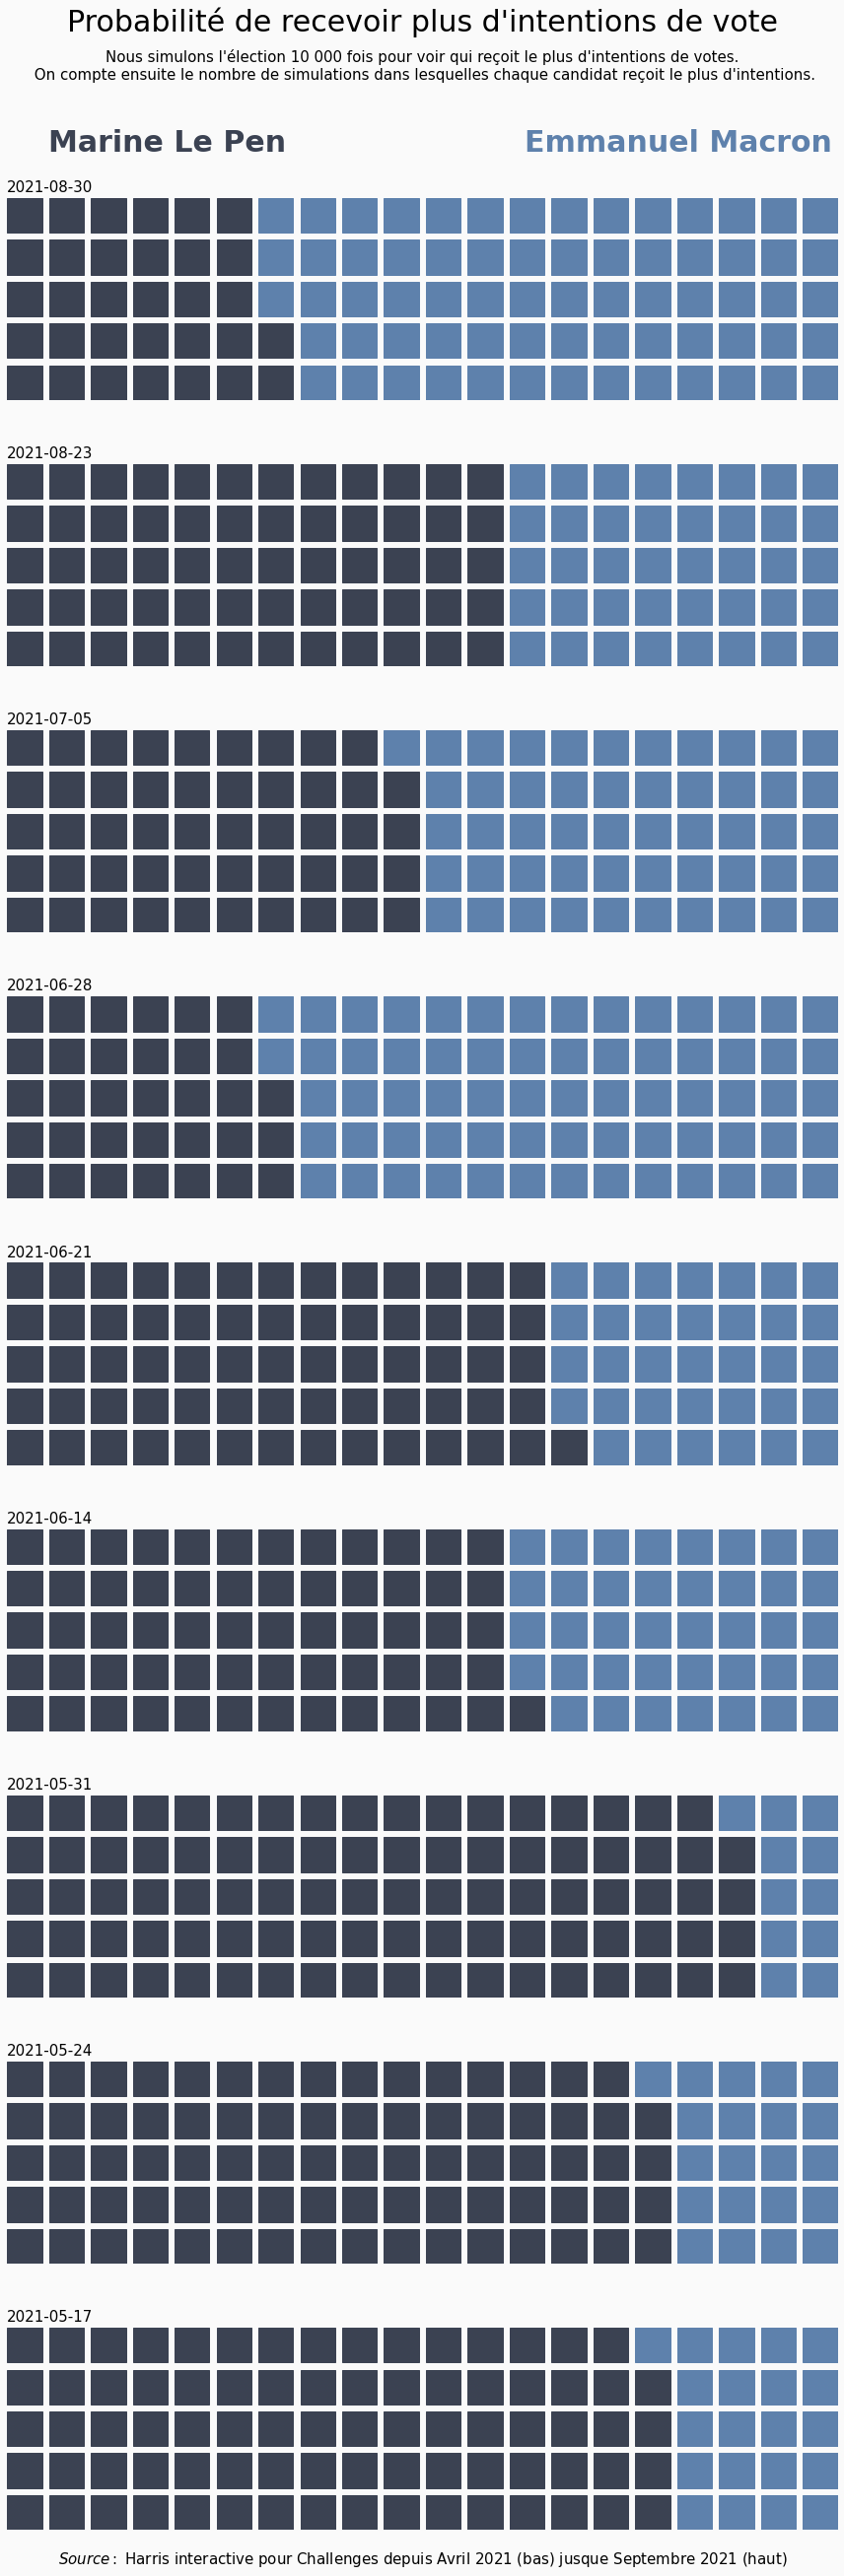

In [146]:
fig = plt.figure(
    FigureClass=Waffle,
    plots = {k: {"values": [int(values), 100-int(values)], "title": {"label": f"{dates[k]}", "loc": "left", "fontsize": 15}
        } for k, values in formatted_data.items()
    },
    rows=5,
    columns=20,  # Either rows or columns could be omitted
    figsize=(12,34),
    colors=["#3b4252","#5e81ac"]
)
fig.text(
    x=0.2,
    y=1,
    ha="center",
    s="Marine Le Pen",
    fontweight="heavy",
    fontsize=30,
    color="#3b4252"
)
fig.text(
    x=0.8,
    y=1,
    ha="center",
    s="Emmanuel Macron",
    fontweight="heavy",
    fontsize=30,
    color="#5e81ac"
)
fig.text(
    x=0.5,
    y=1.05,
    ha="center",
    s="Probabilité de recevoir plus d'intentions de vote",
    fontsize=30
)
fig.text(
    x=0.5,
    y=1.03,
    ha="center",
    s="Nous simulons l'élection 10 000 fois pour voir qui reçoit le plus d'intentions de votes.\n On compte ensuite le nombre de simulations dans lesquelles chaque candidat reçoit le plus d'intentions.",
    fontsize=15
)
fig.text(
    x=0.5,
    y=0,
    ha="center",
    s="$\it{Source:}$ Harris interactive pour Challenges depuis Avril 2021 (bas) jusque Septembre 2021 (haut)",
    fontsize=15
)
fig.show()
fig.set_facecolor('#fafafa')